# Brain decoding with GCN


## Brain graph representation

Graph signal processing is a new tool to model brain organization and function. The brain is composed of several Region of Interests(ROIs). Brain graphs provide an efficient way for modeling the human brain connectome, by associating nodes to the brain regions, and defining edges via anatomical or functional connections. These ROIs are connected to some regions of interests with the highest connectivity.
<br/><br/>

<img src="Brain_connectivity_graph.png" width=545 height=194 />

Representation of Brain connectivity by graph theory. 
Image source:https://atcold.github.io/pytorch-Deep-Learning/en/week13/13-1/ 

## Graph Convolution Network (GCN)
<br/><br/>
<img src="GCN_pipeline_main2022.png" width=680 height=335 />


Schematic view of brain decoding using graph convolution network. Model is adapted from Zhang and colleagues (2021). 
**a)** Bold time series are used to construct the brain graph by associating nodes to predefined brain regions (parcels) and indicating edges between each pair of brain regions based on the strength of their connections. Then, both brain graph and time-series matrix are imported into the graph convolutional network 
**b)** The decoding model consists of three graph convolutional layers with 32 ChebNet graph filters at each layer,  followed by a global average pooling layer, two fully connected layers (MLP, consisting of 256-128 units) and softmax function. This pipeline generates task-specific representations of recorded brain activities and predicts the corresponding cognitive states.

## Getting the data

We are going to download the dataset from Haxby and colleagues (2001) {cite:p}`Haxby2001-vt`. You can check {ref}`haxby-dataset` section for more details on that dataset. Here we are going to quickly download it, and prepare it for machine learning applications with a set of predictive variable, the brain time series, and a dependent variable, the annotation on cognition.

In [1]:
import os
import warnings
warnings.filterwarnings(action='once')
from nilearn.input_data import NiftiMasker

from nilearn import datasets

wdir = os.getcwd()

# We are fetching the data for subject 4
data_dir = os.path.join(wdir, 'data')
sub_no = 2
haxby_dataset = datasets.fetch_haxby(subjects=[sub_no], fetch_stimuli=True, data_dir=data_dir)
func_file = haxby_dataset.func[0]

# Standardizing
mask_vt_file = haxby_dataset.mask_vt[0]
masker = NiftiMasker(mask_img=mask_vt_file, standardize=True)

# cognitive annotations
import pandas as pd
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
X = masker.fit_transform(func_file)
y = behavioral['labels']

/Users/VictoriaShevchenko/.local/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/Users/VictoriaShevchenko/.local/lib/python3.9/site-packages/nilearn/image/resampling.py:453: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn("The provided image has no sform in its header. "


Let's check the shape of X and y and the cognitive annotations of this data sample.

In [2]:
categories = y.unique()
print(categories)
print('y:', y.shape)
print('X:', X.shape)

['rest' 'scissors' 'face' 'cat' 'shoe' 'house' 'scrambledpix' 'bottle'
 'chair']
y: (1452,)
X: (1452, 464)


## Create brain graph for GCN

Here we use subject 2 to construct a graph. First, we compute a functional connectivity matrix.

Correlation matrix shape: (464, 464)


/Users/VictoriaShevchenko/.local/lib/python3.9/site-packages/nilearn/plotting/cm.py:226: PendingDeprecationWarning: The register_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps.register(name)`` instead.
  _cm.register_cmap(name=k, cmap=v)


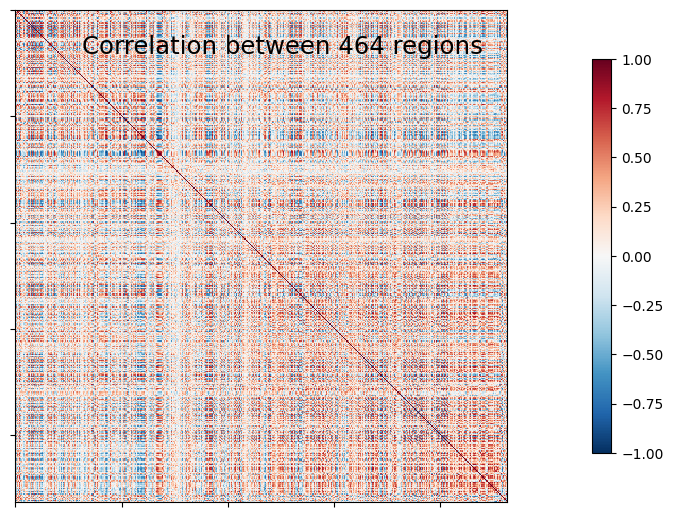

In [3]:
import warnings
warnings.filterwarnings(action='once')

import nilearn.connectome

# Estimating connectomes and save for pytorch to load
corr_measure = nilearn.connectome.ConnectivityMeasure(kind="correlation")
conn = corr_measure.fit_transform([X])[0]

n_regions_extracted = X.shape[-1]
title = 'Correlation between %d regions' % n_regions_extracted

print('Correlation matrix shape:',conn.shape)

# First plot the matrix
from nilearn import plotting
display = plotting.plot_matrix(conn, vmax=1, vmin=-1,
                               colorbar=True, title=title)

The next step is to construct the brain graph for GCN.

__k-Nearest Neighbours(KNN) graph__ for the group average connectome will be built based on the connectivity-matrix.

Each node is only connected to *k* conn = corr_measure.fit_transform([X])[0]
other neighbouring nodes.
For the purpose of demostration, we constrain the graph to from clusters with __8__ neighbouring nodes with the strongest connectivity.

For more details you please check out __*src/graph_construction.py*__ script.

In [4]:
import sys
sys.path.append(wdir + '/src')
from graph_construction import make_group_graph

# make a graph for the subject
graph = make_group_graph([conn], self_loops=False, k=8, symmetric=True)

(464, 464)


## Preparing the dataset for model training

The trials for different object categories are scattered in the experiment. 
Firstly we will concatenated the volumes of the same category together.

In [5]:
# generate data
import pandas as pd
import numpy as np

# cancatenate the same type of trials
concat_bold = {}
for label in categories:
    cur_label_index = y.index[y == label].tolist()
    curr_bold_seg = X[cur_label_index]    
    concat_bold[label] = curr_bold_seg

We split the data by the time window size that we wish to use to caputre the temporal dynamic.
Different lengths for our input data can be selected. 
In this example we will continue with __*window_length = 1*__, which means each input file will have a length equal to just one Repetition Time (TR).
The splitted timeseries are saved as individual files (in the format of `<category>_seg_<serialnumber>.npy`), 
the file names and the associated label are stored in the same directory,
under a file named `label.csv`.

In [6]:
# split the data by time window size and save to file
window_length = 2
dic_labels = {name: i for i, name in enumerate(categories)}

# set output paths
split_path = os.path.join(data_dir, 'haxby_split_win/')
if not os.path.exists(split_path):
    os.makedirs(split_path)
out_file = os.path.join(split_path, '{}_{:04d}.npy')
out_csv = os.path.join(split_path, 'labels.csv')

label_df = pd.DataFrame(columns=['label', 'filename'])
for label, ts_data in concat_bold.items():
    ts_duration = len(ts_data)
    ts_filename = f"{label}_seg"
    valid_label = dic_labels[label]

    # Split the timeseries
    rem = ts_duration % window_length
    n_splits = int(np.floor(ts_duration / window_length))

    ts_data = ts_data[:(ts_duration - rem), :]   

    for j, split_ts in enumerate(np.split(ts_data, n_splits)):
        ts_output_file_name = out_file.format(ts_filename, j)

        split_ts = np.swapaxes(split_ts, 0, 1)
        np.save(ts_output_file_name, split_ts)

        curr_label = {'label': valid_label, 'filename': os.path.basename(ts_output_file_name)}
        label_df = label_df.append(curr_label, ignore_index=True)
        
label_df.to_csv(out_csv, index=False)  

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_82477/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_82477/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_82477/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_82477/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

In [7]:
label_df.shape
label_df["filename"]

0       rest_seg_0000.npy
1       rest_seg_0001.npy
2       rest_seg_0002.npy
3       rest_seg_0003.npy
4       rest_seg_0004.npy
              ...        
721    chair_seg_0049.npy
722    chair_seg_0050.npy
723    chair_seg_0051.npy
724    chair_seg_0052.npy
725    chair_seg_0053.npy
Name: filename, Length: 726, dtype: object

Now we use a customised `pytorch` dataset generator class `TimeWindowsDataset` to split the data into training, 
validation, and testing sets for model selection.

The dataset generator defaults isolates 20% of the data as the validation set, and 10% as testing set.
For more details of customising a dataset, please see `src/gcn_windows_dataset.py` and the 
official [`pytorch` documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files).

In [8]:
# split dataset
from gcn_windows_dataset import TimeWindowsDataset

random_seed = 0

train_dataset = TimeWindowsDataset(
    data_dir=split_path, 
    partition="train", 
    random_seed=random_seed, 
    pin_memory=True, 
    normalize=True,
    shuffle=True)

valid_dataset = TimeWindowsDataset(
    data_dir=split_path, 
    partition="valid", 
    random_seed=random_seed, 
    pin_memory=True, 
    normalize=True,
    shuffle=True)

test_dataset = TimeWindowsDataset(
    data_dir=split_path, 
    partition="test", 
    random_seed=random_seed, 
    pin_memory=True, 
    normalize=True,
    shuffle=True)

print("train dataset: {}".format(train_dataset))
print("valid dataset: {}".format(valid_dataset))
print("test dataset: {}".format(test_dataset))

train dataset: 508*(torch.Size([464, 2]), ())
valid dataset: 145*(torch.Size([464, 2]), ())
test dataset: 73*(torch.Size([464, 2]), ())


Once the datasets are created, we can use the pytorch [data loader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) to iterate through the data during the model selection process.
The __batch size__ defines the number of samples that will be propagated through the neural network.
We are separating the dataset into 10 time windows per batch.

In [9]:
import torch
from torch.utils.data import DataLoader

batch_size = 10

torch.manual_seed(random_seed)
train_generator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_generator = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_generator = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
train_features, train_labels = next(iter(train_generator))
print(f"Feature batch shape: {train_features.size()}; mean {torch.mean(train_features)}")
print(f"Labels batch shape: {train_labels.size()}; mean {torch.mean(torch.Tensor.float(train_labels))}")

Feature batch shape: torch.Size([10, 464, 2]); mean -6.5770642265761126e-09
Labels batch shape: torch.Size([10]); mean 2.5999999046325684


## Generating a GCN model 

We have created a GCN of the following property:
- __3__ graph convolutional layers
- __32 graph filters__  at each layer
- followed by a __global average pooling__ layer
- __2 fully connected__ layers

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import numpy as np


class GCN(torch.nn.Module):
    def __init__(self, edge_index, edge_weight, n_roi, batch_size=16, n_timepoints=1, n_classes=9):
        super().__init__()
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.n_roi = n_roi
        self.batch_size = batch_size

        self.conv1 = tg.nn.ChebConv(
            in_channels=n_timepoints, out_channels=32, K=2, bias=True
        )
        self.conv2 = tg.nn.ChebConv(in_channels=32, out_channels=32, K=2, bias=True)
        self.conv3 = tg.nn.ChebConv(in_channels=32, out_channels=batch_size, K=2, bias=True)
        self.fc1 = nn.Linear(self.n_roi * batch_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, n_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv1(x, self.edge_index, self.edge_weight)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, self.edge_index, self.edge_weight)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, self.edge_index, self.edge_weight)
        x = F.relu(x)
        x = self.dropout(x)
        batch_vector = torch.arange(x.size(0), dtype=int)
        x = torch.flatten(x, 1)
        x = tg.nn.global_mean_pool(x, batch_vector)
        x = x.view(-1, self.n_roi * self.batch_size)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [14]:
from gcn_model import GCN

gcn = GCN(graph.edge_index, 
          graph.edge_attr, 
          n_roi=X.shape[1],
          batch_size=batch_size,
          n_timepoints=window_length, 
          n_classes=len(categories))
gcn

GCN(
  (conv1): ChebConv(2, 32, K=2, normalization=sym)
  (conv2): ChebConv(32, 32, K=2, normalization=sym)
  (conv3): ChebConv(32, 10, K=2, normalization=sym)
  (fc1): Linear(in_features=4640, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=9, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Train and evaluating the model

We will use a procedure called backpropagation to train the model.
When we training the model with the first batch of data, the accuarcy and loss will be pretty poor.
Backpropagation is an algorithm to update the model based on the rate of loss. 
Iterating through each batch, the model will be updated and reduce the loss.

Function `training_loop` performs backpropagation through pytorch. 
One can use their own choice of optimizer for backpropagation and estimator for loss.

After one round of training, we use the validation dataset to calculate the average accuracy and loss with function `valid_test_loop`. 
These metrics will serve as the reference for model performance of this round of training.

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)    

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss, current = loss.item(), batch * dataloader.batch_size

        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= X.shape[0]
        if (batch % 10 == 0) or (current == size):
            print(f"#{batch:>5};\ttrain_loss: {loss:>0.3f};\ttrain_accuracy:{(100*correct):>5.1f}%\t\t[{current:>5d}/{size:>5d}]")

        
def valid_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model.forward(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= size
    correct /= size

    return loss, correct

This whole procedure described above is called an __epoch__.
We will repeat the process for 25 epochs.
Here the choice of loss function is `CrossEntropyLoss` and the optimizer to update the model is `Adam`.

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-4, weight_decay=5e-4)

epochs = 70

avg_acc_train_s2 = []
avg_acc_test_s2 = []
avg_loss_test_s2 = []

for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loop(train_generator, gcn, loss_fn, optimizer)
    loss_train, correct_train = valid_test_loop(valid_generator, gcn, loss_fn)
    loss_test, correct_test = valid_test_loop(test_generator, gcn, loss_fn)
    avg_acc_train_s2.append(correct_train)
    avg_acc_test_s2.append(correct_test)
    avg_loss_test_s2.append(loss_test)

    print(f"Valid metrics:\n\t avg_loss: {loss_train:>8f};\t avg_accuracy: {(100*correct_train):>0.1f}%")

Epoch 1/70
-------------------------------
#    0;	train_loss: 2.201;	train_accuracy:  0.0%		[    0/  508]
#   10;	train_loss: 2.101;	train_accuracy: 30.0%		[  100/  508]
#   20;	train_loss: 1.595;	train_accuracy: 60.0%		[  200/  508]
#   30;	train_loss: 2.032;	train_accuracy: 30.0%		[  300/  508]
#   40;	train_loss: 2.226;	train_accuracy: 20.0%		[  400/  508]
#   50;	train_loss: 1.849;	train_accuracy: 37.5%		[  500/  508]
Valid metrics:
	 avg_loss: 0.199311;	 avg_accuracy: 39.3%
Epoch 2/70
-------------------------------
#    0;	train_loss: 2.127;	train_accuracy: 30.0%		[    0/  508]
#   10;	train_loss: 1.798;	train_accuracy: 40.0%		[  100/  508]
#   20;	train_loss: 1.874;	train_accuracy: 30.0%		[  200/  508]
#   30;	train_loss: 2.368;	train_accuracy: 10.0%		[  300/  508]
#   40;	train_loss: 1.595;	train_accuracy: 50.0%		[  400/  508]
#   50;	train_loss: 1.767;	train_accuracy: 37.5%		[  500/  508]
Valid metrics:
	 avg_loss: 0.182698;	 avg_accuracy: 39.3%
Epoch 3/70
-------------------

In [17]:
np.save(arr = np.asarray(avg_acc_test_s2), file= "avg_acc_test_s2.npy")
np.save(arr = np.asarray(avg_acc_train_s2), file= "avg_acc_train_s2.npy")
np.save(arr = np.asarray(avg_loss_test_s2), file= "avg_loss_test_s2.npy")

# Compare Graph Construction Methods

To compare this graph construction method to the original, refer to notebook `compare_graph_construction.npynb`